In [1]:
%matplotlib inline

This script analyzes radio science experiments for JUICE
computing and plotting Key Performance Indicators (KPIs) such as mean Signal-to-Noise Ratio (SNR),
rms SNR, mean Doppler noise, and mean elevation angle across multiple ground stations.

The workflow includes:
- Loading user-defined parameters (SNR, Doppler noise) and elevation data
- Filtering based on SNR and Doppler noise thresholds
- Computing weighted and unweighted averages
- Visualizing results in a set of subplots

Requirements:
    - The data files where the KPIs are read from are must be present in the output_dir folder, and they are created via experiment_statistics.py .

In [2]:
from pride_characterization_library import PrideDopplerCharacterization
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
def generate_random_color():
    """Generates a random, well-spaced color in hexadecimal format."""
    r = random.randint(0, 220)  # Avoid extremes (too dark/light)
    g = random.randint(0, 220)
    b = random.randint(0, 220)
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

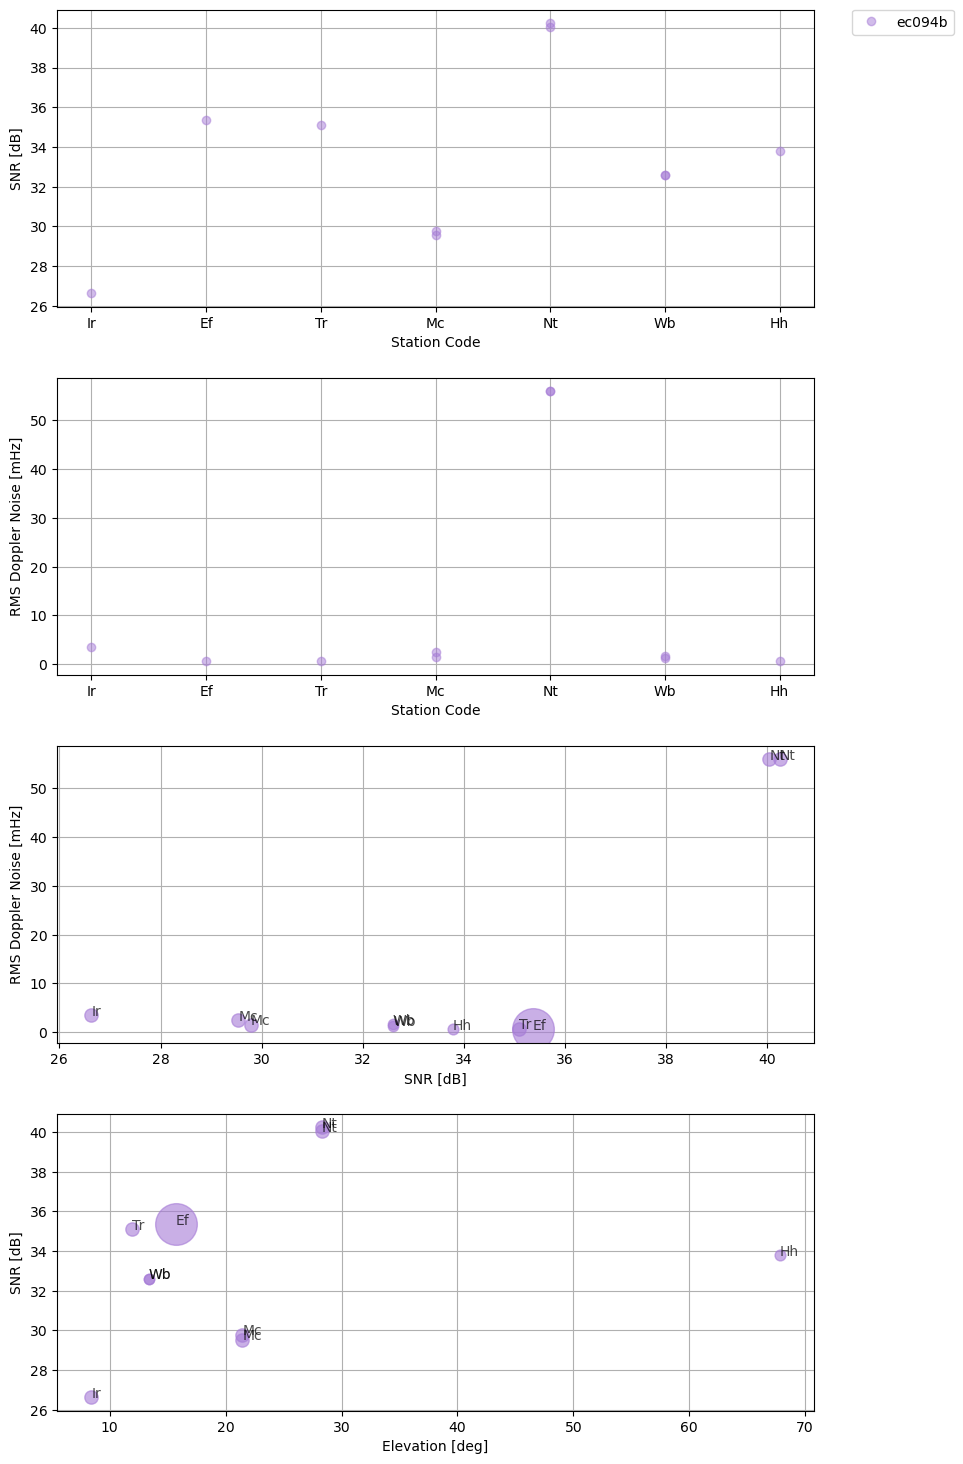

In [4]:
pride = PrideDopplerCharacterization() # create PRIDE Object
process_fdets = pride.ProcessFdets() # create Process Fdets Object
utilities = pride.Utilities() # create Utilities Object
analysis = pride.Analysis(process_fdets, utilities) # create Analysis Object

# Select the experiment(s) for which data analysis will be performed
experiments_to_analyze = {
    'juice': ["ec094b"]
}
# Create empty dictionaries to be filled with meaningful values
mean_rms_user_defined_parameters = defaultdict(list)
mean_elevations = defaultdict(list)
color_dict = defaultdict(list)

# Loop through missions and experiments
for mission_name, experiment_names in experiments_to_analyze.items():
    for experiment_name in experiment_names:
        # Assign color (fixed red for 'vex', random otherwise)
        if mission_name == 'vex':
            color_dict[experiment_name] = 'red'
        else:
            color_dict[experiment_name] = generate_random_color()

        # Define paths for input and output directories
        fdets_folder_path = f'../small_dataset/{mission_name}/{experiment_name}/input/complete' #or insert your path
        output_dir =  f'../small_dataset/{mission_name}/{experiment_name}/output/' #or insert your path
        if not os.path.exists(output_dir):
            print(f'The folder {output_dir} does not exist. Skipping...')
            continue

        # Paths for user-defined parameters and elevation data
        user_defined_parameters_dir = os.path.join(output_dir, 'user_defined_parameters/snr_noise_fdets')
        elevation_dir = os.path.join(output_dir, 'elevation')

        # Analyze user-defined parameter files
        for file in os.listdir(user_defined_parameters_dir):
            station_code = file.split('_')[0]

            # Manual filtering or renaming of station codes
            if mission_name == 'juice' and (station_code == 'O6'): # these are filtered out manually cause we have good reasons
                continue
            elif station_code == 'Ib':
                station_code = 'Ir'
            elif station_code == 'O6':
                station_code = 'On'
            elif mission_name == 'mex' and (station_code == 'Mh' or station_code == 'Ht'): # these are filtered out manually cause we have good reasons
                continue
            elif mission_name == 'min' and (station_code == 'Ir'): # these are filtered out manually cause we have good reasons
                continue

            # Process only TXT files
            if file.endswith('.txt'):
                parameters_dictionary = analysis.read_user_defined_parameters_file(os.path.join(user_defined_parameters_dir, file))

                snr_array = np.array(parameters_dictionary['SNR'])
                doppler_noise_array = np.array(parameters_dictionary['Doppler_noise'])

                # Apply mission-specific SNR and Doppler noise filtering
                if mission_name in ['juice', 'mex', 'vex']:
                    filter_snr = snr_array > 100
                    if experiment_name == 'ec094a' and station_code in ['Wz']:
                        filter_doppler_noise = np.abs(doppler_noise_array) < 0.1
                        filtered_snr = snr_array[filter_snr & filter_doppler_noise]
                        filtered_doppler_noise = doppler_noise_array[filter_snr & filter_doppler_noise]

                    elif experiment_name == 'ec094b' and station_code in ['Mh', 'Nt']:
                        filter_doppler_noise = np.abs(doppler_noise_array) < 0.1
                        filtered_snr = snr_array[filter_snr & filter_doppler_noise]
                        filtered_doppler_noise = doppler_noise_array[filter_snr & filter_doppler_noise]

                    else:
                        filtered_snr = snr_array[filter_snr]
                        filtered_doppler_noise = doppler_noise_array[filter_snr]

                elif mission_name in ['mro', 'min']:
                    filter_snr = snr_array > 30
                    if experiment_name == 'ed045a' and station_code in ['Bd', 'T6', 'Hh']:
                        filter_doppler_noise = np.abs(doppler_noise_array) < 0.1
                        filtered_snr = snr_array[filter_snr & filter_doppler_noise]
                        filtered_doppler_noise = doppler_noise_array[filter_snr & filter_doppler_noise]

                    elif experiment_name == 'ed045e' and station_code in ['Wb']:
                        filter_doppler_noise = np.abs(doppler_noise_array) < 0.1
                        filtered_snr = snr_array[filter_snr & filter_doppler_noise]
                        filtered_doppler_noise = doppler_noise_array[filter_snr & filter_doppler_noise]

                    elif experiment_name == 'ed045f' and station_code in ['Wz']:
                        filter_doppler_noise = np.abs(doppler_noise_array) < 0.1
                        filtered_snr = snr_array[filter_snr & filter_doppler_noise]
                        filtered_doppler_noise = doppler_noise_array[filter_snr & filter_doppler_noise]
                    else:
                        filtered_snr = snr_array[filter_snr]
                        filtered_doppler_noise = doppler_noise_array[filter_snr]

                # Save mean and RMS values
                mean_rms_user_defined_parameters[experiment_name].append({station_code:
                                                                              {'mean_snr': np.mean(filtered_snr),
                                                                               'rms_snr': np.std(filtered_snr),
                                                                               'mean_doppler_noise': np.mean(filtered_doppler_noise),
                                                                               'rms_doppler_noise': np.std(filtered_doppler_noise),
                                                                               }})

        # Analyze elevation files
        for file in os.listdir(elevation_dir):
            station_code = file.split('_')[0]
            if station_code == 'Ib':
                station_code = 'Ir'
            elif station_code == 'O6':
                station_code = 'On'
            if file.endswith('.txt'):
                mean_elevation = analysis.get_mean_elevation_from_file(os.path.join(elevation_dir, file))


                # Update mean elevation in the main dictionary
                for entry in mean_rms_user_defined_parameters[experiment_name]:
                    if station_code in entry:
                        entry[station_code]['mean_elevation'] = mean_elevation

# Initialize labels and plot
labels_snr = set()
labels_doppler = set()
labels_snr_vs_noise = set()
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=False)
ax1, ax2, ax3, ax4 = axes  # Assign subplots

# Compute weighted and unweighted averages
for experiment_name in mean_rms_user_defined_parameters.keys():
    # compute the mean of KPIs among all stations belonging to the experiment (table 5 in Vidhya's paper)
    aggregate = defaultdict(lambda: {'sum': 0, 'count': 0})
    # First pass: Compute the unweighted means for elevation, snr and rms snr
    for entry in mean_rms_user_defined_parameters[experiment_name]:
        for station, values in entry.items():
            for key, value in values.items():
                if key not in ['mean_doppler_noise', 'rms_doppler_noise']:
                    aggregate[key]['sum'] += value
                    aggregate[key]['count'] += 1

    # Compute the mean values before applying weights
    mean_values_old = {key: aggregate[key]['sum'] / aggregate[key]['count'] for key in aggregate}

    # Second pass: Apply weights using SNR
    aggregate_weighted = defaultdict(lambda: {'sum': 0, 'count': 0})
    for entry in mean_rms_user_defined_parameters[experiment_name]:
        for station, values in entry.items():
            if np.abs(values['mean_doppler_noise']) < 10: # We set a threshold for the highest acceptable value (in mHz) of Doppler noise (< 0.1 Hz)
                for key, value in values.items():
                    snr_weight = values.get('mean_snr')
                    if key in ['mean_doppler_noise', 'rms_doppler_noise']:
                        aggregate_weighted[key]['sum'] += value * snr_weight
                        aggregate_weighted[key]['count'] += snr_weight
            else:
                continue

    # Compute the weighted mean values
    mean_values_new = {key: (aggregate_weighted[key]['sum'] / aggregate_weighted[key]['count'])*1000 for key in aggregate_weighted}
    merged_dict = {**mean_values_old, **mean_values_new}

# Plotting results
for experiment_name in mean_rms_user_defined_parameters.keys():
    for station_dict in mean_rms_user_defined_parameters[experiment_name]:
        for station in station_dict.keys():
            try:
                antenna_diameter = utilities.antenna_diameters[station]
            except:
                continue
            mean_snr = 10*np.log10(station_dict[station]['mean_snr']) #in dB units
            rms_snr = 10*np.log10(station_dict[station]['rms_snr']) #in dB units
            mean_doppler = station_dict[station]['mean_doppler_noise']*1000 #in mHz
            rms_doppler = station_dict[station]['rms_doppler_noise']*1000 #in mHz
            mean_elevation = station_dict[station]['mean_elevation']

            # Plot SNR on the first subplot
            if experiment_name[0] == 'v':
                ax1.errorbar(station, mean_snr, linewidth=2, fmt='o', markersize=6, alpha=0.5,
                             color=color_dict[experiment_name], label='Venus Express 2014/10' if 'Venus Express 2014/10' not in labels_snr else None)
                labels_snr.add('Venus Express 2014/10')

                # Plot Doppler Noise on the second subplot
                ax2.errorbar(station, rms_doppler, linewidth=2, fmt='o', markersize=6, alpha=0.5,
                             color=color_dict[experiment_name])

                # Plot SNR vs. Doppler Noise on the third subplot
                ax3.errorbar(mean_snr, rms_doppler, fmt='o',markersize=3*antenna_diameter/10, alpha=0.6,
                             color=color_dict[experiment_name])
                ax3.annotate(station, (mean_snr, rms_doppler), fontsize=10, alpha=0.7)

                labels_snr_vs_noise.add('Venus Express 2014/01')

                ax4.errorbar(mean_elevation, mean_snr, fmt='o', markersize=3*antenna_diameter/10, alpha=0.6,
                             color=color_dict[experiment_name])
                ax4.annotate(station, (mean_elevation, mean_snr), fontsize=10, alpha=0.7)

            else:

                ax1.errorbar(station, mean_snr, linewidth=2, fmt='o', markersize=6, alpha=0.5,
                             color=color_dict[experiment_name], label=experiment_name if experiment_name not in labels_snr else None)
                labels_snr.add(experiment_name)

                # Plot Doppler Noise on the second subplot
                ax2.errorbar(station, rms_doppler, linewidth=2, fmt='o', markersize=6, alpha=0.5,
                             color=color_dict[experiment_name])

                # Plot SNR vs. Doppler Noise on the third subplot
                ax3.errorbar(mean_snr, rms_doppler, fmt='o',markersize=3*antenna_diameter/10, alpha=0.6,
                             color=color_dict[experiment_name])
                ax3.annotate(station, (mean_snr, rms_doppler), fontsize=10, alpha=0.7)

                labels_snr_vs_noise.add(experiment_name)

                ax4.errorbar(mean_elevation, mean_snr, fmt='o', markersize=3*antenna_diameter/10, alpha=0.6,
                             color=color_dict[experiment_name])
                ax4.annotate(station, (mean_elevation, mean_snr), fontsize=10, alpha=0.7)

            # only keep good observations (where good: rms_doppler < 0.5 Hz)
            if np.abs(mean_doppler) > 10: #in mHz (< 0.1 Hz)
                ax1.errorbar(station, mean_snr, linewidth=2, fmt='x', markersize=6, alpha=0.7,
                             color='red')
                # Plot Doppler Noise on the second subplot
                ax2.errorbar(station, rms_doppler, linewidth=2, fmt='x', markersize=6, alpha=0.7,
                             color='red')
                # Plot SNR vs. Doppler Noise on the third subplot
                ax3.errorbar(mean_snr, rms_doppler, fmt='x',markersize=3*antenna_diameter/10, alpha=0.7,
                             color='red')
                ax3.annotate(station, (mean_snr, rms_doppler), fontsize=10, alpha=0.7)

                labels_snr_vs_noise.add(experiment_name)

                ax4.errorbar(mean_elevation, mean_snr, fmt='x', markersize=3*antenna_diameter/10, alpha=0.7,
                             color='red')
                ax4.annotate(station, (mean_elevation, mean_snr), fontsize=10, alpha=0.7)


# Final plot adjustments
ax1.set_ylabel('SNR [dB]')
ax1.set_xlabel(f'Station Code')
ax1.grid()
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Formatting Doppler Noise subplot
ax2.set_ylabel(f'RMS Doppler Noise [mHz]')
ax2.set_xlabel(f'Station Code')
ax2.grid()

# Formatting SNR vs. Doppler Noise subplot
ax3.set_xlabel('SNR [dB]')
ax3.set_ylabel('RMS Doppler Noise [mHz]')
ax3.grid()

# Formatting SNR vs. Doppler Noise subplot
ax4.set_xlabel('Elevation [deg]')
ax4.set_ylabel('SNR [dB]')
ax4.grid()

plt.savefig(output_dir + experiment_name + '_dataset_statistics.png')

plt.tight_layout(pad=2)
plt.show()